In [ ]:
#!pip uninstall xgboost -y
#!pip uninstall lightgbm -y
#!pip uninstall scikit-learn -y
#!pip uninstall pandas -y
#!pip uninstall numpy -y
#!pip uninstall matplotlib -y
#!pip uninstall seaborn -y
#!pip uninstall prophet -y
#!pip uninstall tensorflow -y
#!pip uninstall scikeras -y

# @title Install packages
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost==2.1.1
!pip install scikeras==0.13.0
!pip install tensorflow==2.17.0
!pip install prophet==1.1.5
!pip install scikit-learn==1.4.2
!pip install plotly


Found existing installation: xgboost 2.1.1
Uninstalling xgboost-2.1.1:
  Successfully uninstalled xgboost-2.1.1
Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
Found existing installation: pandas 2.1.4
Uninstalling pandas-2.1.4:
  Successfully uninstalled pandas-2.1.4
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: matplotlib 3.9.1
Uninstalling matplotlib-3.9.1:
  Successfully uninstalled matplotlib-3.9.1
Found existing installation: seaborn 0.13.0
Uninstalling seaborn-0.13.0:
  Successfully uninstalled seaborn-0.13.0
Found existing installation: prophet 1.1.5
Uninstalling prophet-1.1.5:
  Successfully uninstalled prophet-1.1.5
Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: scikeras 0.13.0
Uninstalling scikeras-0.13

  Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.4 MB)
  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1


In [ ]:
#@title Install Libraries
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import scikeras
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet
import xgboost as xgb
import plotly.graph_objects as go
#!pip freeze > requirements.txt
#from google.colab import files
#files.download('requirements.txt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preparation and Feature Engineering
LSTM XGBOOST & Prophet

---

In [ ]:
# @title Reading file path from drive
file_path = '/content/drive/My Drive/Colab Notebooks/Wind_Turbine_Power_Prediction/Location1.csv'
df=pd.read_csv(file_path,parse_dates=['Time'], index_col='Time')

NameError: name 'pd' is not defined

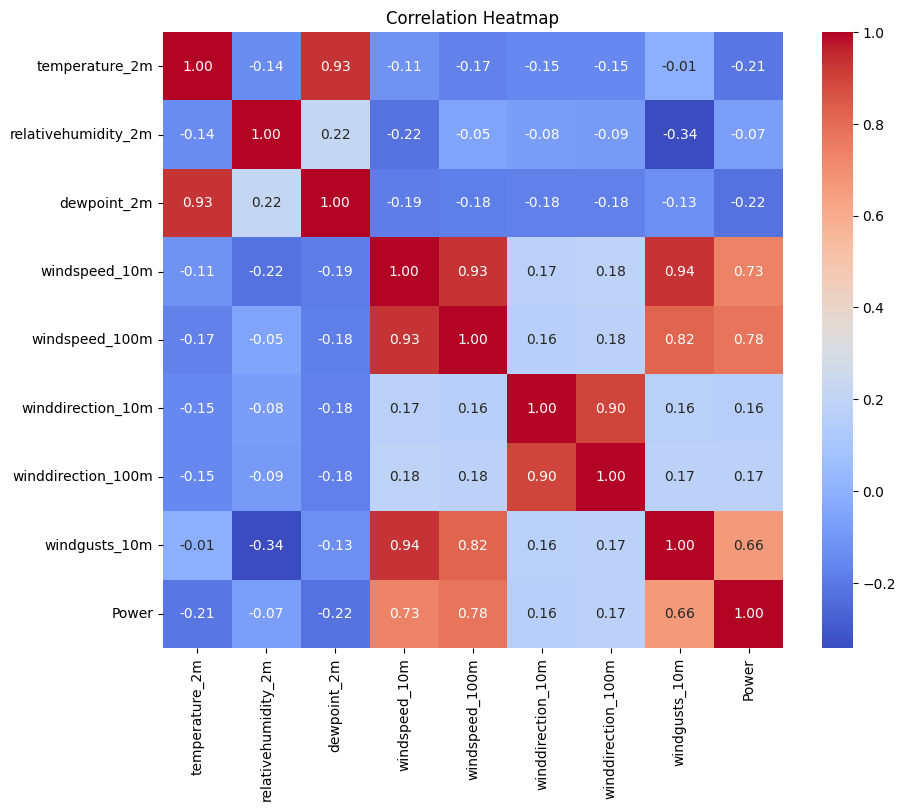

In [ ]:
#@title Correlation Heatmap
# Calculate the correlation matrix
corr_matrix = df.corr()
# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#@title Data Preparation
#df.rename(columns={'Power': 'target'}, inplace=True)
df=df.reset_index()
df = df[['Time','Power','temperature_2m', 'relativehumidity_2m','dewpoint_2m', 'windspeed_10m','windspeed_100m','winddirection_10m','winddirection_100m','windgusts_10m']].rename(columns={'Time': 'ds', 'Power': 'y'})
#____________________________________________________________________
#Extract day,month, year, hours,day of the week
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.dayofweek

# Creating cyclic features
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24) #10
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24) #11
df['sin_dayofweek'] = np.sin(2 * np.pi * df['dayofweek'] / 7)#12
df['cos_dayofweek'] = np.cos(2 * np.pi * df['dayofweek'] / 7)#13
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)#14
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)#15
#df = df.drop(['hour', 'dayofweek', 'day', 'month', 'year'], axis=1)
df=df.set_index('ds')

# Apply sine and cosine transformations for the direction angle
df['winddirection_10m'] = np.deg2rad(df['winddirection_10m'])
df['winddirection_100m'] = np.deg2rad(df['winddirection_100m'])
df['sin_winddirection_10m'] = np.sin(df['winddirection_10m'])
df['cos_winddirection_10m'] = np.cos(df['winddirection_10m'])
df['sin_winddirection_100m'] = np.sin(df['winddirection_100m'])#16
df['cos_winddirection_100m'] = np.cos(df['winddirection_100m'])#17
#df = df.drop(['winddirection_10m', 'winddirection_100m'], axis=1) # Specify the columns to drop and the axis (1 for columns)
#______________________________________________________________________
#Create  lags for windspeed
df['Windspeed_10m_lagged_1'] = df['windspeed_10m'].shift(1) #18
df['Windspeed_10m_lagged_2'] = df['windspeed_10m'].shift(2) #19
df['Windspeed_100m_lagged_1'] = df['windspeed_100m'].shift(1) #20
df['Windspeed_100m_lagged_2'] = df['windspeed_100m'].shift(2) #21

#______________________________________________________________________
#Rolling mean window for windspeed_100m
# daily moving average
df['daily_ma_wind'] = df['windspeed_100m'].rolling(window=24).mean() #22
# Weekly moving average
df['weekly_ma_wind'] = df['windspeed_100m'].rolling(window=168).mean() #23
# Monthly moving average (approximate, assuming 30 days per month)
df['monthly_ma_wind'] = df['windspeed_100m'].rolling(window=720).mean() #24
# Quarterly moving average (approximate, assuming 90 days per quarter)
df['quarterly_ma_wind'] = df['windspeed_100m'].rolling(window=2160).mean() #25

#________________________________________________________________________
# Sum of Temperature  and Humidity convert temperature to °C #
df['temperature_2m'] = (df['temperature_2m'] - 32) * 5/9
df['temperature_sum'] = df['temperature_2m'] + df['relativehumidity_2m'] #26
df['temperature_diff'] = df['temperature_2m'] - df['relativehumidity_2m'] #27

#_________________________________________________________________________
#Division of temp and wind speed # variable 8
df['Q_Div_Temp_wind'] = (df['temperature_2m']/df['windspeed_100m']) #28

#__________________________________________________________________________
#Windspeed log transform
df['windspeed_10m'] = df['windspeed_10m'].replace(0, 0.0001)
df['windspeed_100m'] = df['windspeed_100m'].replace(0, 0.0001)
df['Windspeed_10m_lagged_1'] =df['Windspeed_10m_lagged_1'].replace(0, 0.0001)
df['Windspeed_100m_lagged_1'] =df['Windspeed_100m_lagged_1'].replace(0, 0.0001)
# Calculate logarithmic returns (assuming non-zero values)
df['log_Wind_100m'] = np.log(df['windspeed_100m'] / df['Windspeed_100m_lagged_1']) #29

#___________________________________________________________________________
#Temperature Moving subtraction
df['temp_lagged'] = df['temperature_2m'].shift(1) #30
df['Temp_Moving_sub'] = df['temperature_2m'] - df['temp_lagged'] #31

#_____________________________________________________________________________
#Moving subtraction of wind
df['Wind_Moving_sub'] = df['windspeed_100m'] - df['Windspeed_100m_lagged_1'] #32

#Log(Target(i)/Target(i-1)) variable 1
# Replace 0 values in 'target' column with 0.0001
df['y'] = df['y'].replace(0, 0.0001)
# Calculate the lagged target
df['y_lagged'] = df['y'].shift(24)
df['y_lagged'] = df['y_lagged'].fillna(method='bfill')
# Calculate logarithmic returns (assuming non-zero values)
df['log_return_y'] = np.log(df['y'] / df['y_lagged'])

# Assuming 'data' is your DataFrame and 'target' is the column with your values
# Weekly moving average (p = 7) variable 2
df['daily_ma_y'] = df['y'].rolling(window=24).mean()
# Weekly moving average (p = 7) variable 3
df['weekly_ma_y'] = df['y'].rolling(window=168).mean()
# Monthly moving average (approximate, assuming 30 days per month) variable 4
df['monthly_ma_y'] = df['y'].rolling(window=720).mean()
# Quarterly moving average (approximate, assuming 90 days per quarter) variable 5
df['quarterly_ma_y'] = df['y'].rolling(window=2160).mean()

#Wind power Moving subtraction # variable 9
df['wind_power_Moving_sub'] = df['y'] - df['y_lagged']

#Wind shear calculation
df['Wind_sin_10m']= df['windspeed_10m']*df['sin_winddirection_10m']
df['Wind_cos_10m']= df['windspeed_10m']*df['cos_winddirection_10m']
df['Wind_cos_100m']= df['windspeed_100m']*df['cos_winddirection_100m']
df['Wind_sin_100m']= df['windspeed_100m']*df['sin_winddirection_100m']
df['Wind_shear']=  (np.sqrt((df['Wind_cos_100m']- df['Wind_cos_10m'])**2 + (df['Wind_sin_100m']- df['Wind_sin_10m'])**2)/(100-10))


<ipython-input-13-56c9fe58c439>:82: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y_lagged'] = df['y_lagged'].fillna(method='bfill')


In [ ]:
#@title Calculate Air density
# Function to calculate air density
def calculate_air_density(temp_2m, rel_humidity_2m, dew_point_2m, altitude):
    Rd = 287.05
    Rv = 461.495
    p0 = 101325
    L = 0.0065
    T0 = 288.15
    g = 9.80665
    M = 0.0289644
    R = 8.3144598

    temp_k_2m = temp_2m + 273.15
    lapse_rate = 0.0098
    temp_c_100m = temp_2m - lapse_rate * (altitude - 2)
    temp_k_100m = temp_c_100m + 273.15

    e_s = 6.112 * math.exp((17.67 * dew_point_2m) / (dew_point_2m + 243.5))
    e = e_s * (rel_humidity_2m / 100)

    p = p0 * (1 - (L * altitude) / T0) ** (g * M / (R * L))
    p_d = p - e

    rho = (p_d / (Rd * temp_k_100m)) + (e / (Rv * temp_k_100m))

    return rho

# Calculate air density at 100m height for each row
df['air_density_100m'] = df.apply(lambda row: calculate_air_density(row['temperature_2m'],
                                                                    row['relativehumidity_2m'],
                                                                    row['dewpoint_2m'],
                                                                    100), axis=1)

df['Wind_power_density'] =0.5*df['air_density_100m']*df['windspeed_100m']**3

In [ ]:
df=df.dropna()

In [ ]:
from google.colab import files
dfd=df[['y', 'Wind_power_density', 'daily_ma_y', 'Windspeed_100m_lagged_1', 'Windspeed_100m_lagged_2',
                  'daily_ma_wind', 'windspeed_100m', 'Wind_shear', 'Wind_cos_100m', 'windgusts_10m', 'temperature_sum']]
dfd.to_csv('Location1_final.csv')
files.download('Location1_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

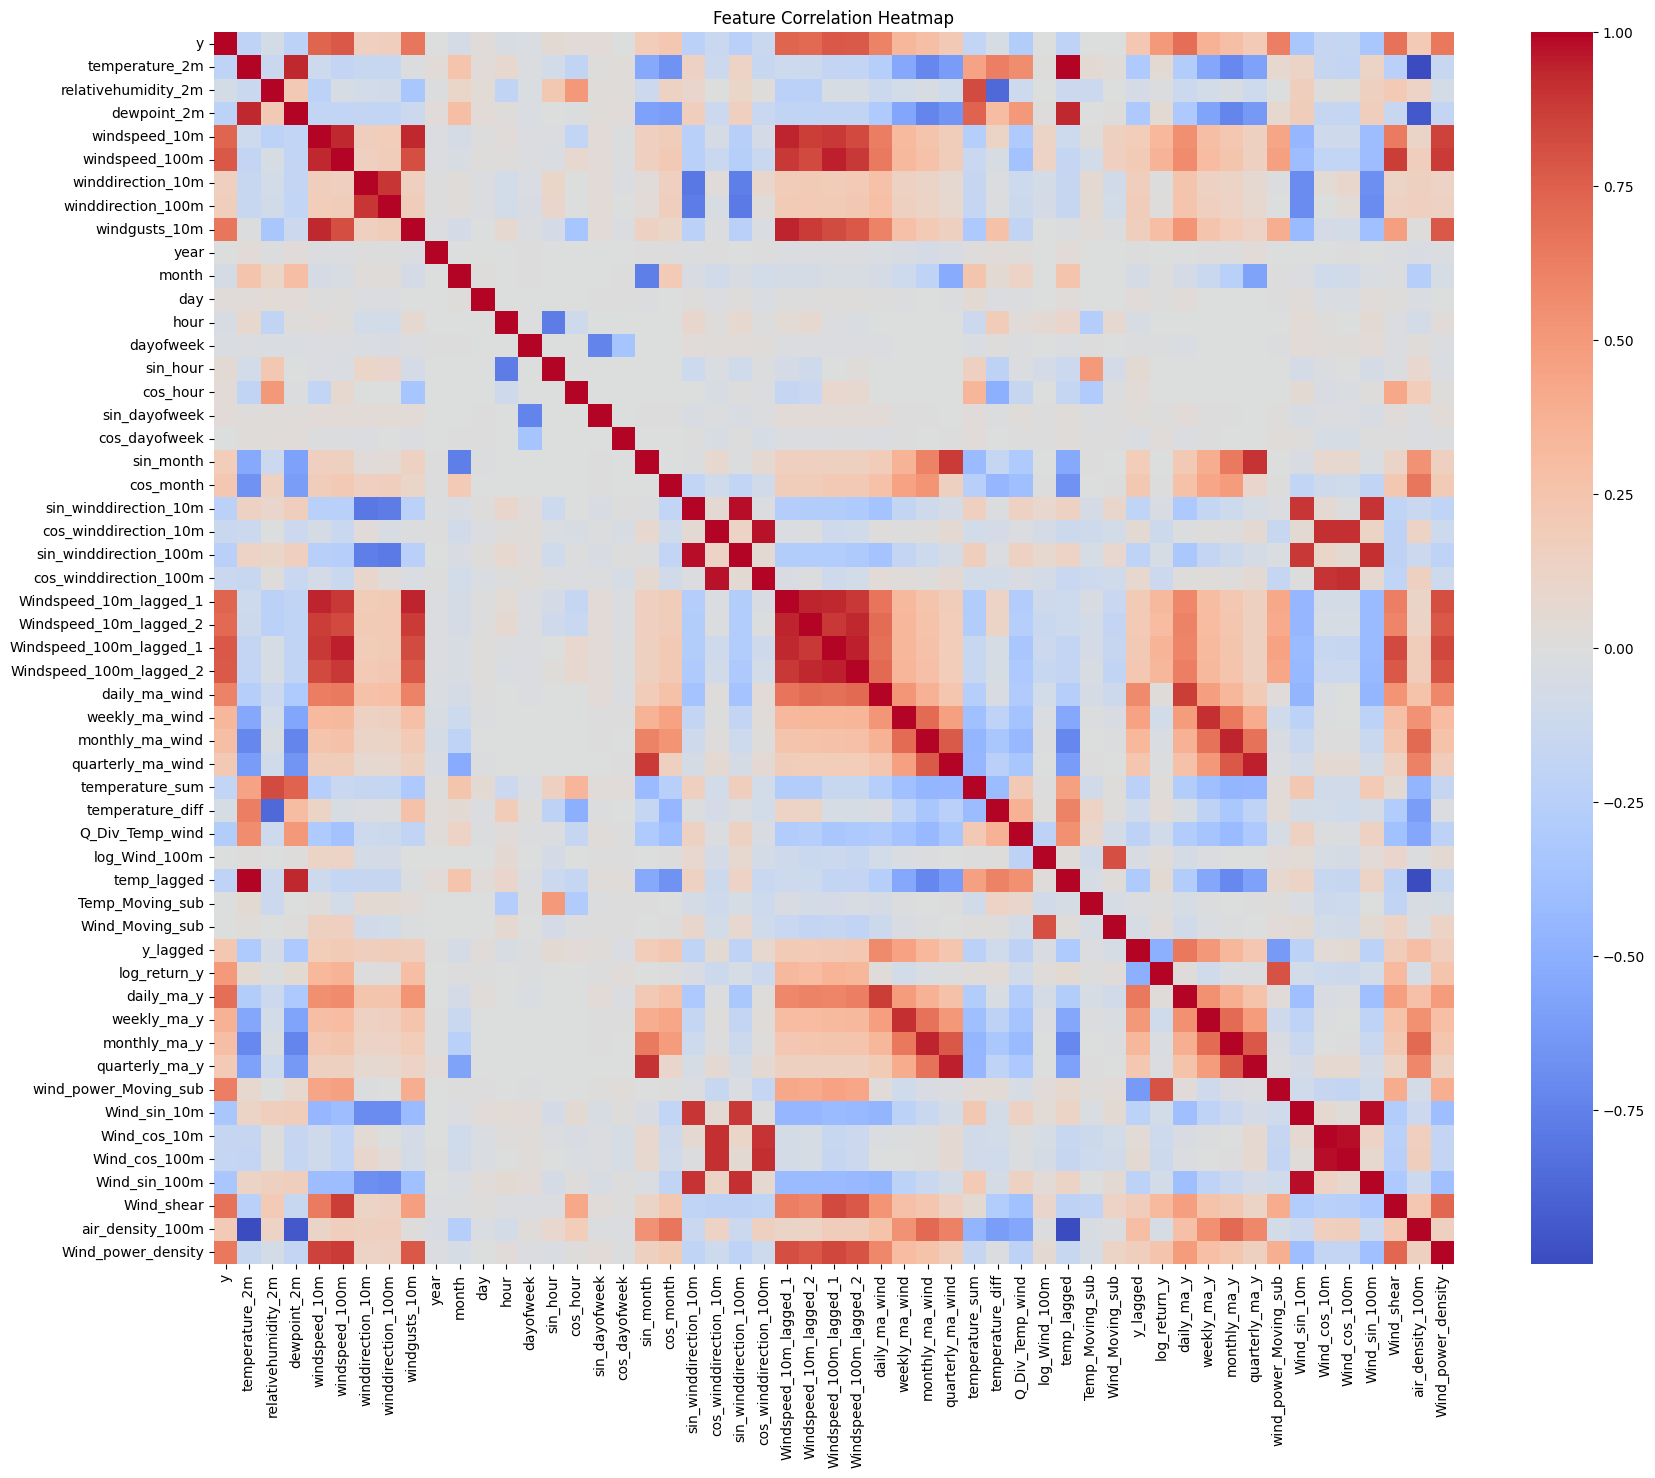

In [ ]:
#@title corr heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called 'df'
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Select features with correlation to target above a threshold
threshold = 0.5
selected_features = correlation_matrix['y'].abs().sort_values(ascending=False)
selected_features = selected_features[selected_features > threshold].index.tolist()

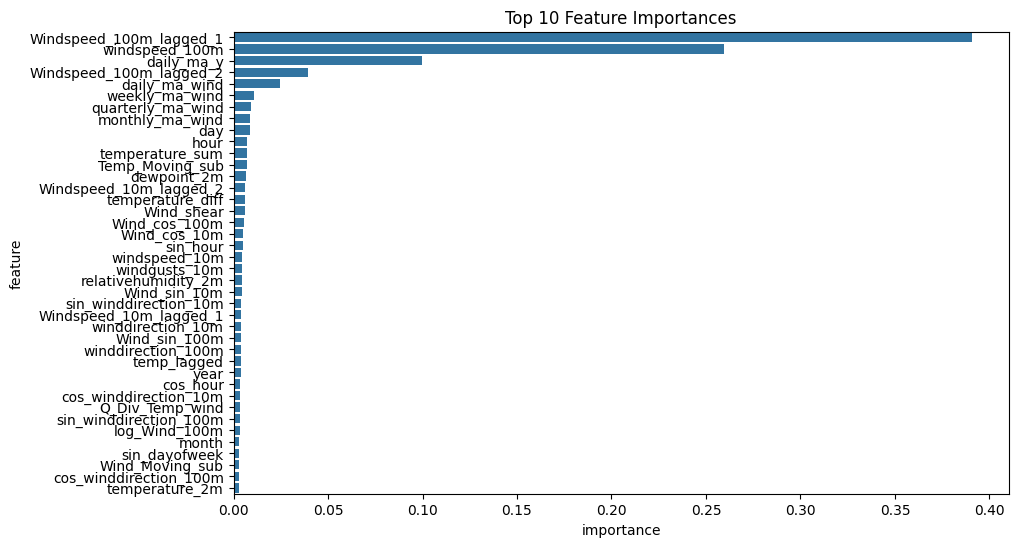

In [ ]:
#@title Random Forest feature selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

y_features=['y','y_lagged','log_return_y','weekly_ma_y','monthly_ma_y','quarterly_ma_y','wind_power_Moving_sub']
X = df.drop(y_features, axis=1)
y = df['y']
#,'daily_ma_y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(40))
plt.title('Top 10 Feature Importances')
plt.show()

In [ ]:
features = ['Wind_power_density','Windspeed_100m_lagged_1', 'Windspeed_100m_lagged_2',
            'daily_ma_wind', 'windspeed_100m', 'Wind_shear', 'Wind_cos_100m',
            'windgusts_10m', 'temperature_sum']

In [ ]:
# @title LSTM Forecast
from tensorflow.keras.layers import Bidirectional
df_lstm = df.reset_index().rename(columns={'index': 'ds'})
df_lstm=df_lstm.set_index('ds')
df_lstm=df_lstm[['y','Wind_power_density', 'Windspeed_100m_lagged_1', 'Windspeed_100m_lagged_2',
            'daily_ma_wind', 'windspeed_100m', 'Wind_shear', 'Wind_cos_100m',
            'windgusts_10m', 'temperature_sum']] #change it as per the feature selection

# @title data preparing for the LSTM
from sklearn.preprocessing import MinMaxScaler

# @title Normalize the data by scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

def create_sequences(data, seq_length):
    xs, ys = [], []
    #for i in range(seq_length, len_data)
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, 1:]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Number of time steps
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
#train_size = int(len(X) * 0.8)

X_train, X_test, X_test2 = X[:-17520], X[-17520:-8760], X[-8760:]
y_train, y_test, y_test2 = y[:-17520], y[-17520:-8760] ,y[-8760:]

#features =['Wind_power_density', 'daily_ma_y', 'Windspeed_100m_lagged_1', 'Windspeed_100m_lagged_2',
 #           'daily_ma_wind', 'windspeed_100m', 'Wind_shear', 'Wind_cos_100m',
  #          'windgusts_10m', 'temperature_sum']

optimizers_dict = {
    'SGD': tf.keras.optimizers.SGD,
    'Adam': tf.keras.optimizers.Adam
}

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# @title Training the model4
def build_final_model(window_size, num_units, activation, optimizer, learning_rate):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, input_shape=(window_size, len(features)))),
        Dropout(0.2),
        Bidirectional(LSTM(16, return_sequences=False)),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    optimizer = optimizers_dict[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model



# Using the best parameters for window size 5
final_model4 = build_final_model(
    window_size=24,
    num_units=64,
    activation='sigmoid',
    optimizer='Adam',
    learning_rate=0.01
)

# Train the final model
final_model4.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 84s 122ms/step - loss: 0.1741 - val_loss: 0.0982
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - loss: 0.1095 - val_loss: 0.0758
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - loss: 0.0889 - val_loss: 0.0695
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 80s 110ms/step - loss: 0.0831 - val_loss: 0.0664
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 89s 122ms/step - loss: 0.0797 - val_loss: 0.0783
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 80s 119ms/step - loss: 0.0800 - val_loss: 0.0675
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 78s 114ms/step - loss: 0.0756 - val_loss: 0.0650
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 84s 117ms/step - loss: 0.0739 - val_loss: 0.0647
Epoch 9/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 90s 131ms/step - loss: 0.0743 - val_loss: 0.0583
Epoch 10/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - loss: 0.0727 - val_loss: 0.0611
Epoch 11/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - loss: 0.0702 - val_loss: 0.0583
Epoch 12/50
603/603 ━━━━━━━━━━

In [ ]:
# Save the model
final_model4.save('lstm_model.h5')  # HDF5 format
from google.colab import files
files.download('lstm_model.h5')
from tensorflow.keras.models import load_model
model_lstm = load_model('lstm_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title For streamlit app
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

# Function to load data
def load_data():
    df = pd.read_csv('Location1.csv', parse_dates=['ds'], index_col='ds')
    return df

# Function to preprocess data
def preprocess_data(df, seq_length):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:i+seq_length, 1:]
            y = data[i+seq_length, 0]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    X, y = create_sequences(scaled_data, seq_length)
    return X, y, scaler

# Function to plot results and display accuracy metrics
def plot_and_evaluate(df, model, start_date, end_date):
    # Filter data based on user input
    df_lstm = df[['y', 'Wind_power_density', 'daily_ma_y', 'Windspeed_100m_lagged_1', 'Windspeed_100m_lagged_2',
                  'daily_ma_wind', 'windspeed_100m', 'Wind_shear', 'Wind_cos_100m', 'windgusts_10m', 'temperature_sum']]

    SEQ_LENGTH = 24
    X, y, scaler = preprocess_data(df_lstm, SEQ_LENGTH)

    predictions = model.predict(X)
    predictions_reshaped = np.zeros((predictions.shape[0], len(df_lstm.columns)))
    predictions_reshaped[:, 0] = predictions.flatten()
    predictions_original_scale = scaler.inverse_transform(predictions_reshaped)
    predictions_power = predictions_original_scale[:, 0]

    # Create a DataFrame with predictions and datetime index
    predictions_df = pd.DataFrame(predictions_power, index=df.index[SEQ_LENGTH:], columns=['Predicted_Power'])

    # Filter the data for the plot
    actual_data = df.loc[start_date:end_date, 'y']
    predicted_data = predictions_df.loc[start_date:end_date, 'Predicted_Power']

    # Plot the results
    plt.figure(figsize=(15, 6))
    plt.plot(actual_data.index, actual_data, label='Actual')
    plt.plot(predicted_data.index, predicted_data, label='Predicted')
    plt.title('Actual vs Predicted Power')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.legend()
    plt.show()

    # Accuracy metrics
    mse = mean_squared_error(actual_data, predicted_data)
    mae = mean_absolute_error(actual_data, predicted_data)
    r2 = r2_score(actual_data, predicted_data)

    st.write(f'Validation set Mean Squared Error (MSE): {mse}')
    st.write(f'Validation set Mean Absolute Error (MAE): {mae}')
    st.write(f'Validation set R-squared (R²): {r2}')

# Streamlit interface
st.title('Wind Energy Prediction')

# Load the model
model = load_model('lstm_model.h5')

# Load and display the data
df = load_data()
st.write('Data:', df)

# Input from the user
start_date = st.date_input('Select start date', value=pd.to_datetime('2021-01-01'))
end_date = st.date_input('Select end date', value=pd.to_datetime('2021-12-31'))

# Plot and evaluate
if st.button('Plot and Evaluate'):
    plot_and_evaluate(df, model, start_date, end_date)


274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step


<ipython-input-22-24f95200f3bb>:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_time, periods=len(predictions_power), freq='H')
<ipython-input-22-24f95200f3bb>:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index2 = pd.date_range(start=start_time2, periods=len(predictions_power2), freq='H')


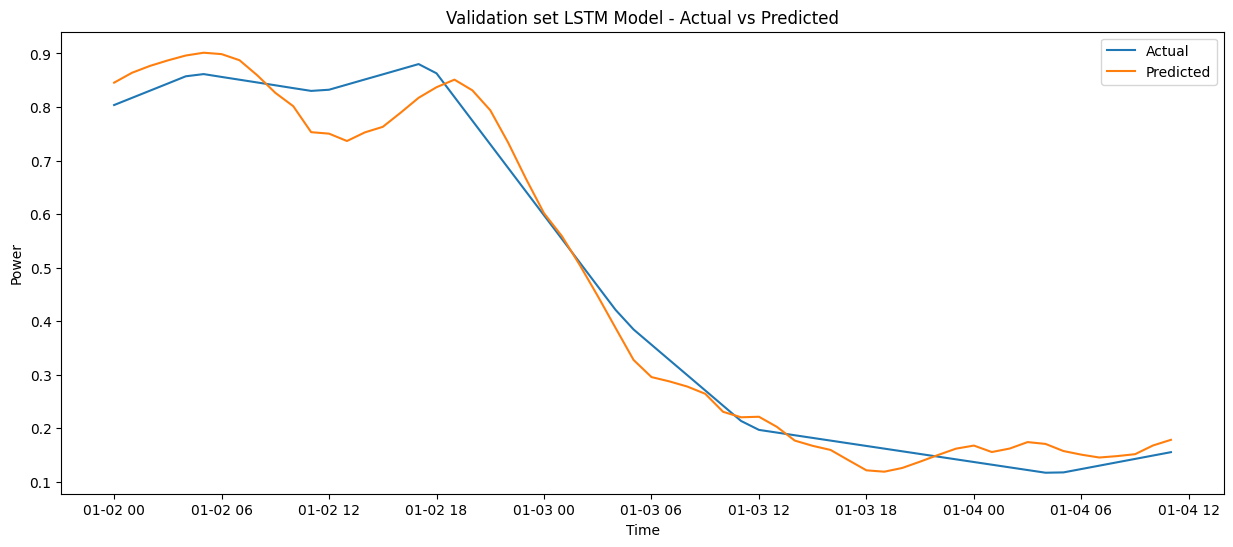

Validation set Mean Squared Error (MSE): 0.005728359235395921
Validation set Mean Absolute Error (MAE): 0.057164837234979636
Validation set R-squared (R²): 0.9320813143142598


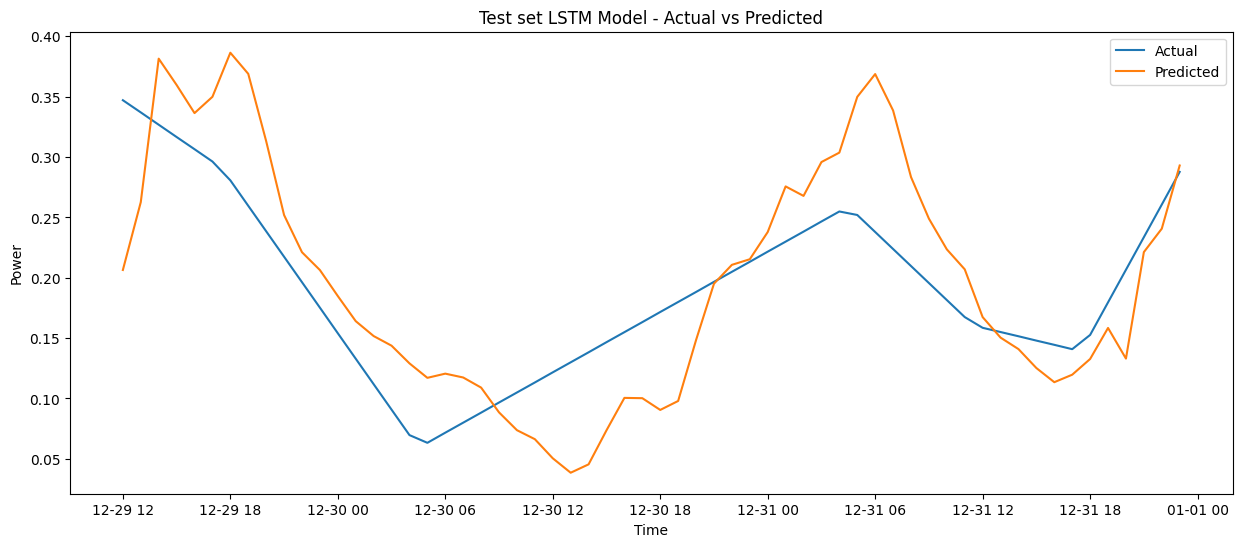

Test set Mean Squared Error (MSE): 0.0061541079470347395
Test set Mean Absolute Error (MAE): 0.05866641851562072
Test set R-squared (R²): 0.9311422972655324


In [ ]:
# @title B1) Make predictions
predictions = model_lstm.predict(X_test)
predictions2 = model_lstm.predict(X_test2)

# @title inverse scaling/transforming validation set
# Reshape predictions to match the original dataset's number of columns
predictions_reshaped = np.zeros((predictions.shape[0], 11)) #******** change the shape as to no of features + 'y'
predictions_reshaped[:, 0] = predictions.flatten()  # Put predictions in the first column (assuming 'power' was the first column)
# Inverse transform to get predictions in the original scale
predictions_original_scale = scaler.inverse_transform(predictions_reshaped)
# Extract the inverse-transformed 'power' predictions
predictions_power = predictions_original_scale[:, 0]
# Calculate the adjusted start time (assuming hourly frequency)
start_time = pd.to_datetime('2020-01-02 00:00:00') # Add 24 hours
# Create a datetime index starting from the adjusted start time
time_index = pd.date_range(start=start_time, periods=len(predictions_power), freq='H')
# Create a Pandas Series with the predictions and the correct time index
predictions_series = pd.Series(predictions_power, index=time_index)
predictions_series= pd.DataFrame(predictions_series)
predictions_series.rename(columns={0: 'y'}, inplace=True)
#predictions_series

# @title inverse scaling/transforming validation set
# Reshape predictions to match the original dataset's number of columns
predictions_reshaped2 = np.zeros((predictions2.shape[0], 11)) #******** change the shape as to no of features + 'y'
predictions_reshaped2[:, 0] = predictions2.flatten()  # Put predictions in the first column (assuming 'power' was the first column)
# Inverse transform to get predictions in the original scale
predictions_original_scale2 = scaler.inverse_transform(predictions_reshaped2)
# Extract the inverse-transformed 'power' predictions
predictions_power2 = predictions_original_scale2[:, 0]
# Calculate the adjusted start time (assuming hourly frequency)
start_time2 = pd.to_datetime('2021-01-01 00:00:00') # Add 24 hours
# Create a datetime index starting from the adjusted start time
time_index2 = pd.date_range(start=start_time2, periods=len(predictions_power2), freq='H')
# Create a Pandas Series with the predictions and the correct time index
predictions_series2 = pd.Series(predictions_power2, index=time_index2)
predictions_series2= pd.DataFrame(predictions_series2)
predictions_series2.rename(columns={0: 'y'}, inplace=True)
#predictions_series2

# @title  Plot the validation results
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(df_lstm.index[-17520:-17460], df_lstm['y'][-17520:-17460], label='Actual')
plt.plot(predictions_series['y'][:60], label='Predicted')
plt.title('Validation set LSTM Model - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()

#Accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Extract the actual values (this should match the length of your forecast period)
actual_values = df_lstm['y'].values[-17520:-8760]  # Adjust the slicing as per your forecast period
# Extract the predicted values
predicted_values = predictions_series['y'] # Adjust the slicing as per your forecast period
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f'Validation set Mean Squared Error (MSE): {mse}')
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f'Validation set Mean Absolute Error (MAE): {mae}')
# Calculate R-squared (R²)
r2 = r2_score(actual_values, predicted_values)
print(f'Validation set R-squared (R²): {r2}')

# @title  Plot the test results
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(df_lstm.index[-60:], df_lstm['y'][-60:], label='Actual')
plt.plot(predictions_series2['y'][-60:], label='Predicted')
plt.title('Test set LSTM Model - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show();

#Accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Extract the actual values (this should match the length of your forecast period)
actual_values = df_lstm['y'].values[-8760:]  # Adjust the slicing as per your forecast period
# Extract the predicted values
predicted_values = predictions_series2['y'] # Adjust the slicing as per your forecast period
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f'Test set Mean Squared Error (MSE): {mse}')
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f'Test set Mean Absolute Error (MAE): {mae}')
# Calculate R-squared (R²)
r2 = r2_score(actual_values, predicted_values)
print(f'Test set R-squared (R²): {r2}')

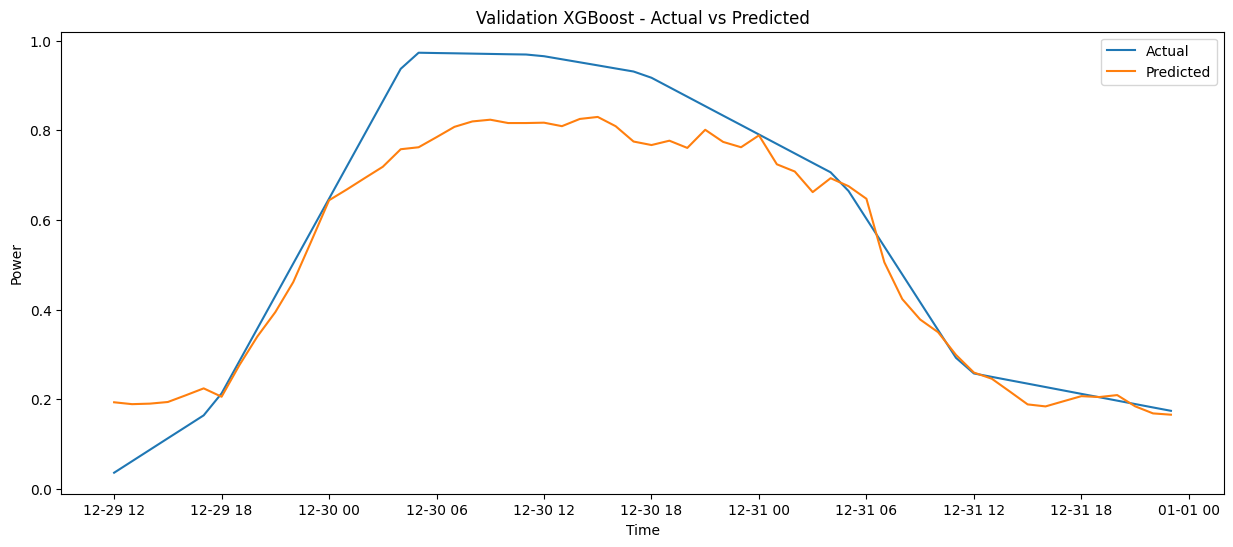

Validation set Mean Squared Error: 0.022919720777915785
Validation set Mean Absolute Error (MAE): 0.1151263025685097
Validation set R-squared (R²): 0.7282507525189104


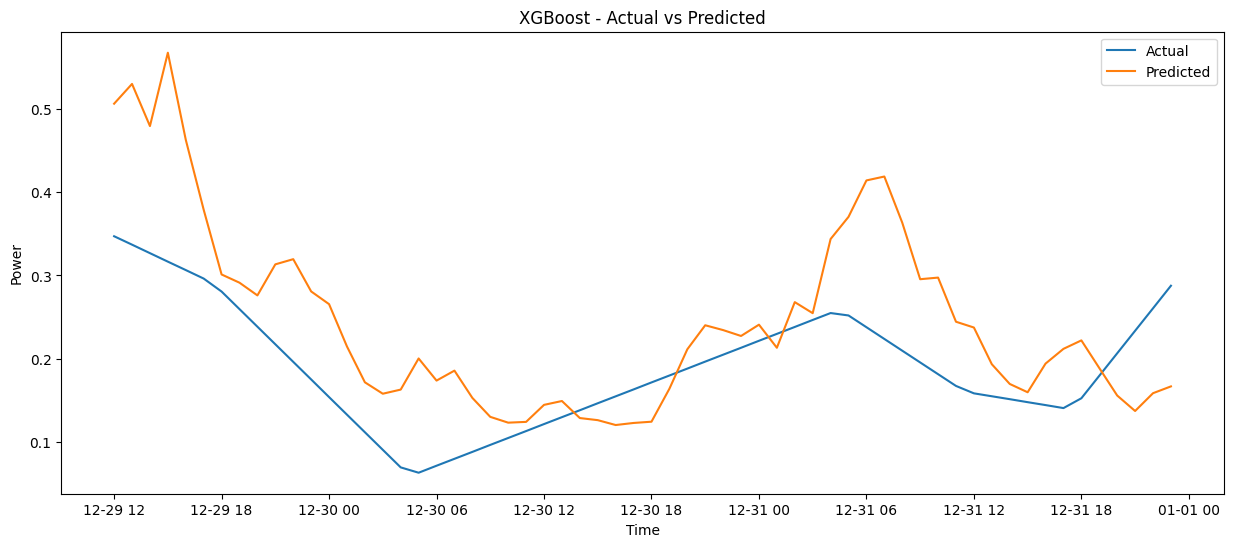

Test set Mean Squared Error: 0.02488732100536896
Test set Mean Absolute Error (MAE): 0.1223754977371241
Test set R-squared (R²): 0.7215382365090496


In [ ]:
#@title XGBoost Forecast
X= df[features]
y= df['y']

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, X_test2 = X[:-17520], X[-17520:-8760], X[-8760:]
y_train, y_test, y_test2 = y[:-17520], y[-17520:-8760] ,y[-8760:]

# @title Training the XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define the model
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.9,
    subsample=0.7,
    learning_rate=0.05,
    max_depth=4,
    alpha=10,
    n_estimators=200
)

# Train the model
model_xgb.fit(X_train, y_train)

# @title Predictions
# Make predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
predictions = model_xgb.predict(X_test)
predictions2 = model_xgb.predict(X_test2)

#Validation set

plt.figure(figsize=(15, 6))
plt.plot(y_test.index[-60:], y_test[-60:], label='Actual')
plt.plot(y_test.index[-60:], predictions[-60:], label='Predicted')
plt.title('Validation XGBoost - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show();


# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)
print(f'Validation set Mean Squared Error: {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Validation set Mean Absolute Error (MAE): {mae}')

# Calculate R-squared (R²)
r2 = r2_score(y_test, predictions)
print(f'Validation set R-squared (R²): {r2}')

#Test set

plt.figure(figsize=(15, 6))
plt.plot(y_test2.index[-60:], y_test2[-60:], label='Actual')
plt.plot(y_test2.index[-60:], predictions2[-60:], label='Predicted')
plt.title('XGBoost - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show();


# Calculate the mean squared error
mse = mean_squared_error(y_test2, predictions2)
print(f'Test set Mean Squared Error: {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test2, predictions2)
print(f'Test set Mean Absolute Error (MAE): {mae}')

# Calculate R-squared (R²)
r2 = r2_score(y_test2, predictions2)
print(f'Test set R-squared (R²): {r2}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkzn5gbzq/bwx85y9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkzn5gbzq/_7sknhlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19542', 'data', 'file=/tmp/tmpkzn5gbzq/bwx85y9y.json', 'init=/tmp/tmpkzn5gbzq/_7sknhlx.json', 'output', 'file=/tmp/tmpkzn5gbzq/prophet_modelwhc3dbyn/prophet_model-20240730223157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:32:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


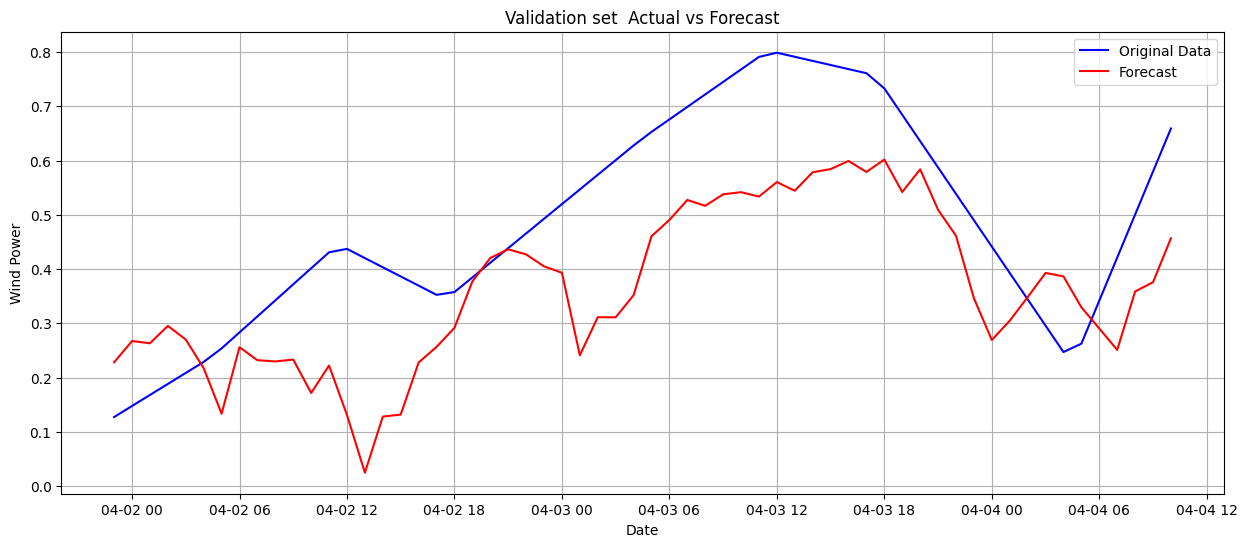

Validation set Mean Squared Error (MSE): 0.02789146122758426
Validation Mean Absolute Error (MAE): 0.1305203912475699
Validation R-squared (R²): 0.6588219752


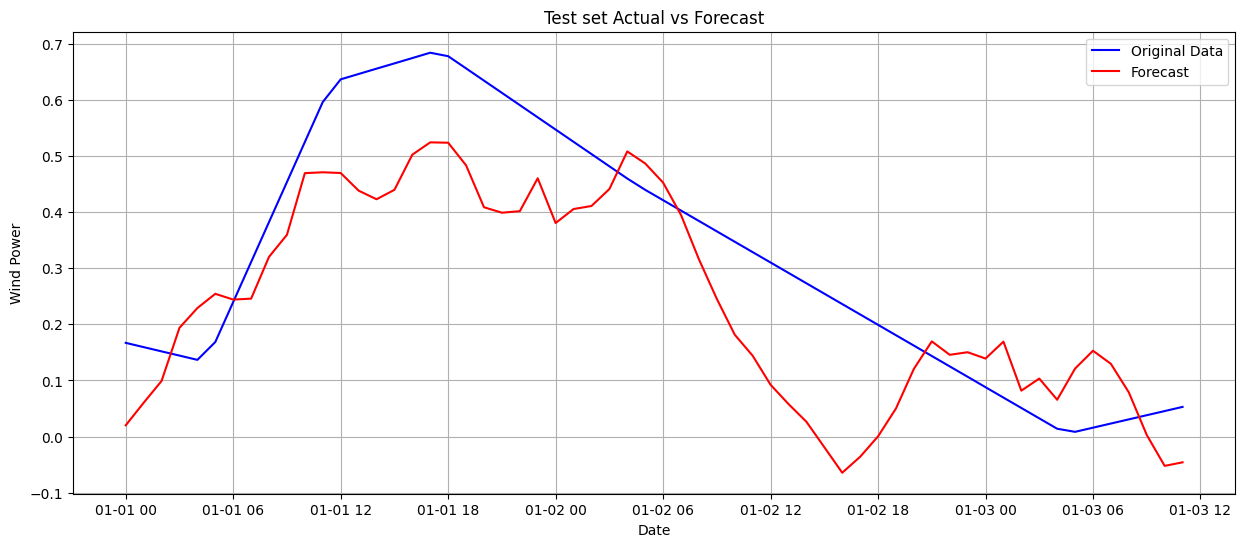

Test set Mean Squared Error (MSE): 0.029655563246088777
Test set Mean Absolute Error (MAE): 0.13730330239560457
Test set R-squared (R²): 0.6681868476


In [ ]:
#@title Prophet Forecast
from sklearn.model_selection import train_test_split
df_prophet2=df[['y','Wind_power_density','daily_ma_y' ,'Windspeed_100m_lagged_1', 'Windspeed_100m_lagged_2',
            'daily_ma_wind', 'windspeed_100m', 'Wind_shear', 'Wind_cos_100m',
            'windgusts_10m', 'temperature_sum']] #change it as per the feature selection
df_prophet2=df_prophet2.reset_index()
df_prophet=df_prophet2[:-8760]

train_df = df_prophet[df_prophet['ds'] <= '2019-12-31 23:00:00']  # Adjust date as needed
test_df = df_prophet[df_prophet['ds'] > '202-12-31 23:00:00']
test_df2= df_prophet2[-8760:]

# @title A1) Training the model
# @title Initialize and fit the model Add additional regressors var1,...var4
model_prophet = Prophet(growth='linear',daily_seasonality=True, yearly_seasonality=True, seasonality_prior_scale=10,
                        changepoint_prior_scale=0.01, n_changepoints=50, changepoint_range=0.9)
model_prophet.add_regressor('Wind_power_density')
model_prophet.add_regressor('daily_ma_y')
model_prophet.add_regressor('Windspeed_100m_lagged_1')
model_prophet.add_regressor('Windspeed_100m_lagged_2')
model_prophet.add_regressor('daily_ma_wind')
model_prophet.add_regressor('windspeed_100m')
model_prophet.add_regressor('Wind_shear')
model_prophet.add_regressor('Wind_cos_100m')
model_prophet.add_regressor('windgusts_10m')
model_prophet.add_regressor('temperature_sum')
#model_prophet.add_regressor('wind_power_Moving_sub')
#Training and fitting the model
model_prophet.fit(train_df)
# @title A1) Forecast and measurement metrics
forecast = model_prophet.predict(test_df)
forecast2 = model_prophet.predict(test_df2)


# @title Verifiing the forecast
# Plot the training data and forecast validation set
plt.figure(figsize=(15, 6))
plt.plot( test_df['ds'][:60], test_df['y'][:60] , label='Original Data', color='blue')
# Plot the forecasted data
plt.plot(forecast['ds'][:60], forecast['yhat'][:60], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Wind Power')
plt.title('Validation set  Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show(block=True)

#Validation Accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
actual_values = test_df['y'] # Adjust the slicing as per your forecast period
# Extract the predicted values
predicted_values = forecast['yhat']  # Adjust the slicing as per your forecast period
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f'Validation set Mean Squared Error (MSE): {mse}')
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f'Validation Mean Absolute Error (MAE): {mae}')
# Calculate R-squared (R²)
r2 = r2_score(actual_values, predicted_values)
print(f'Validation R-squared (R²): {r2:.10f}')


# @title Verifiing the forecast
# Plot the training data and forecast test set
plt.figure(figsize=(15, 6))
plt.plot( test_df2['ds'][:60], test_df2['y'][:60] , label='Original Data', color='blue')
# Plot the forecasted data
plt.plot(forecast2['ds'][:60], forecast2['yhat'][:60], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Wind Power')
plt.title('Test set Actual vs Forecast')
plt.legend()
plt.grid(True)
plt.show(block=True)

#Testing Accuracy metrics
actual_values = test_df2['y'] # Adjust the slicing as per your forecast period
# Extract the predicted values
predicted_values = forecast2['yhat']  # Adjust the slicing as per your forecast period
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f'Test set Mean Squared Error (MSE): {mse}')
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f'Test set Mean Absolute Error (MAE): {mae}')
# Calculate R-squared (R²)
r2 = r2_score(actual_values, predicted_values)
print(f'Test set R-squared (R²): {r2:.10f}')

#Previous metrics without sine/cosine transformation
#Mean Squared Error (MSE): 0.031076702608488434
#Mean Absolute Error (MAE): 0.1414710663876729
#R-squared (R²): 0.6522859683268815
#With sine transform variable
#Mean Squared Error (MSE): 0.029569340665650163
#Mean Absolute Error (MAE): 0.13765922722113172
#R-squared (R²): 0.669151686190776

#ARIMA

In [ ]:
# @title Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

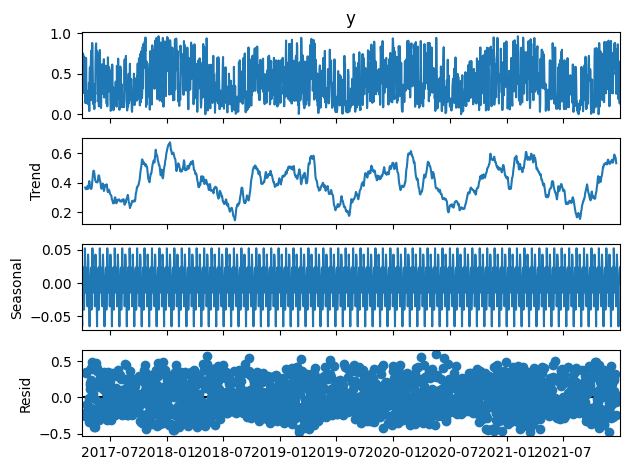

In [ ]:
# @title Decompose the time series
result = seasonal_decompose(df['y'], model='additive', period=24)
result.plot()
plt.show()


In [ ]:
#@title test for stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
          print('Critical Values:')
          print(f'   {key}, {value}')

# Assuming 'df' is your DataFrame
test_stationarity(df['y'])

ADF Statistic: -4.970892502569214
p-value: 2.5333145675142372e-05
Critical Values:
   1%, -3.434175427574795
Critical Values:
   5%, -2.8632297119111967
Critical Values:
   10%, -2.567669556525133


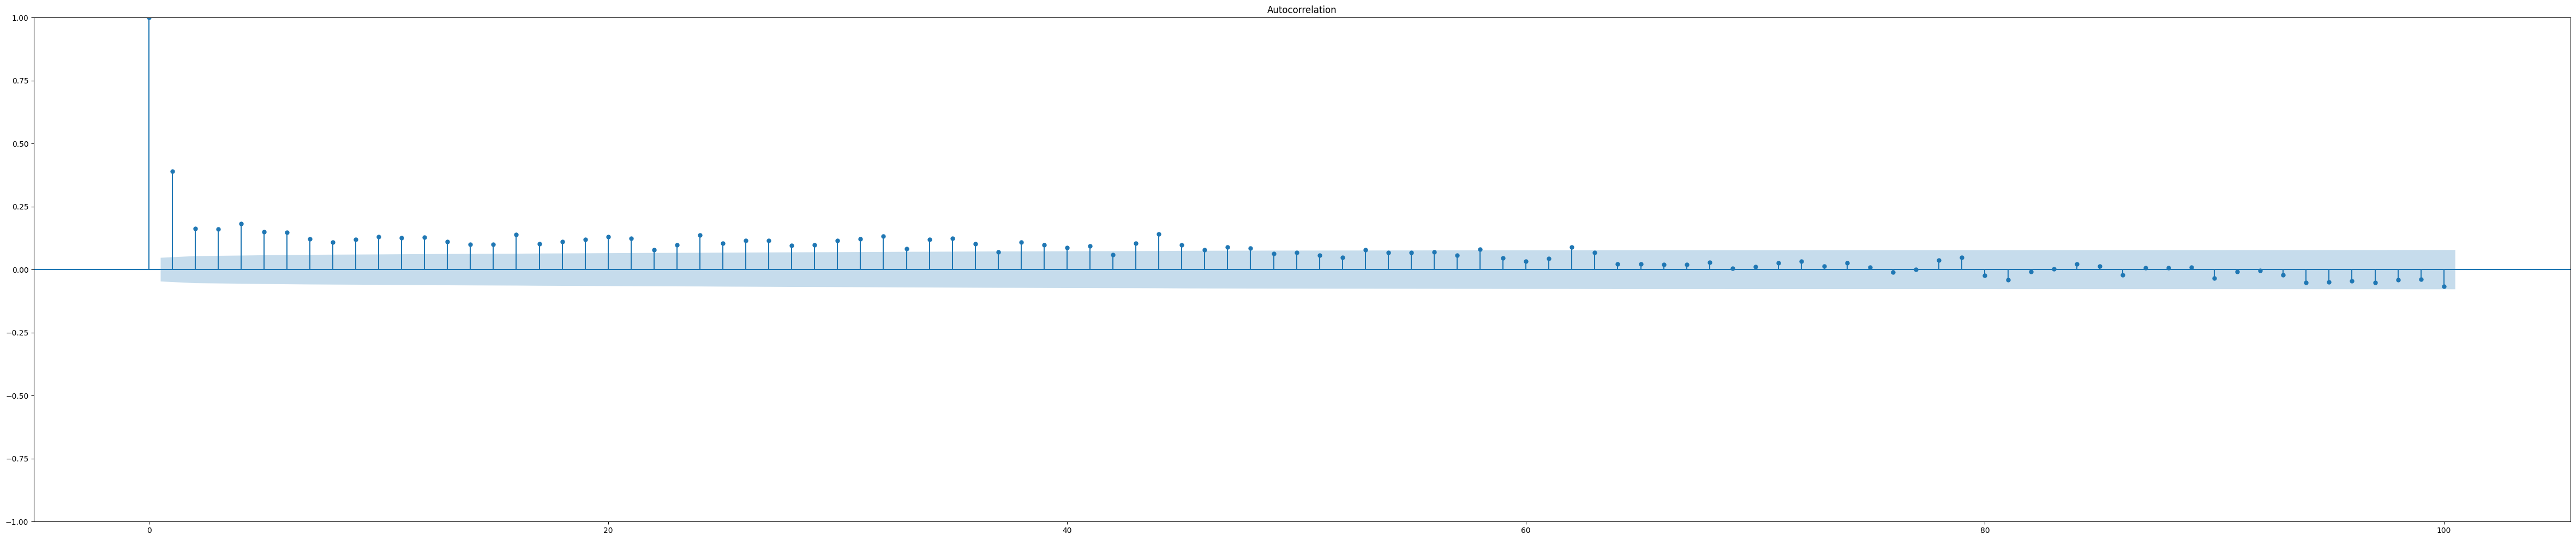

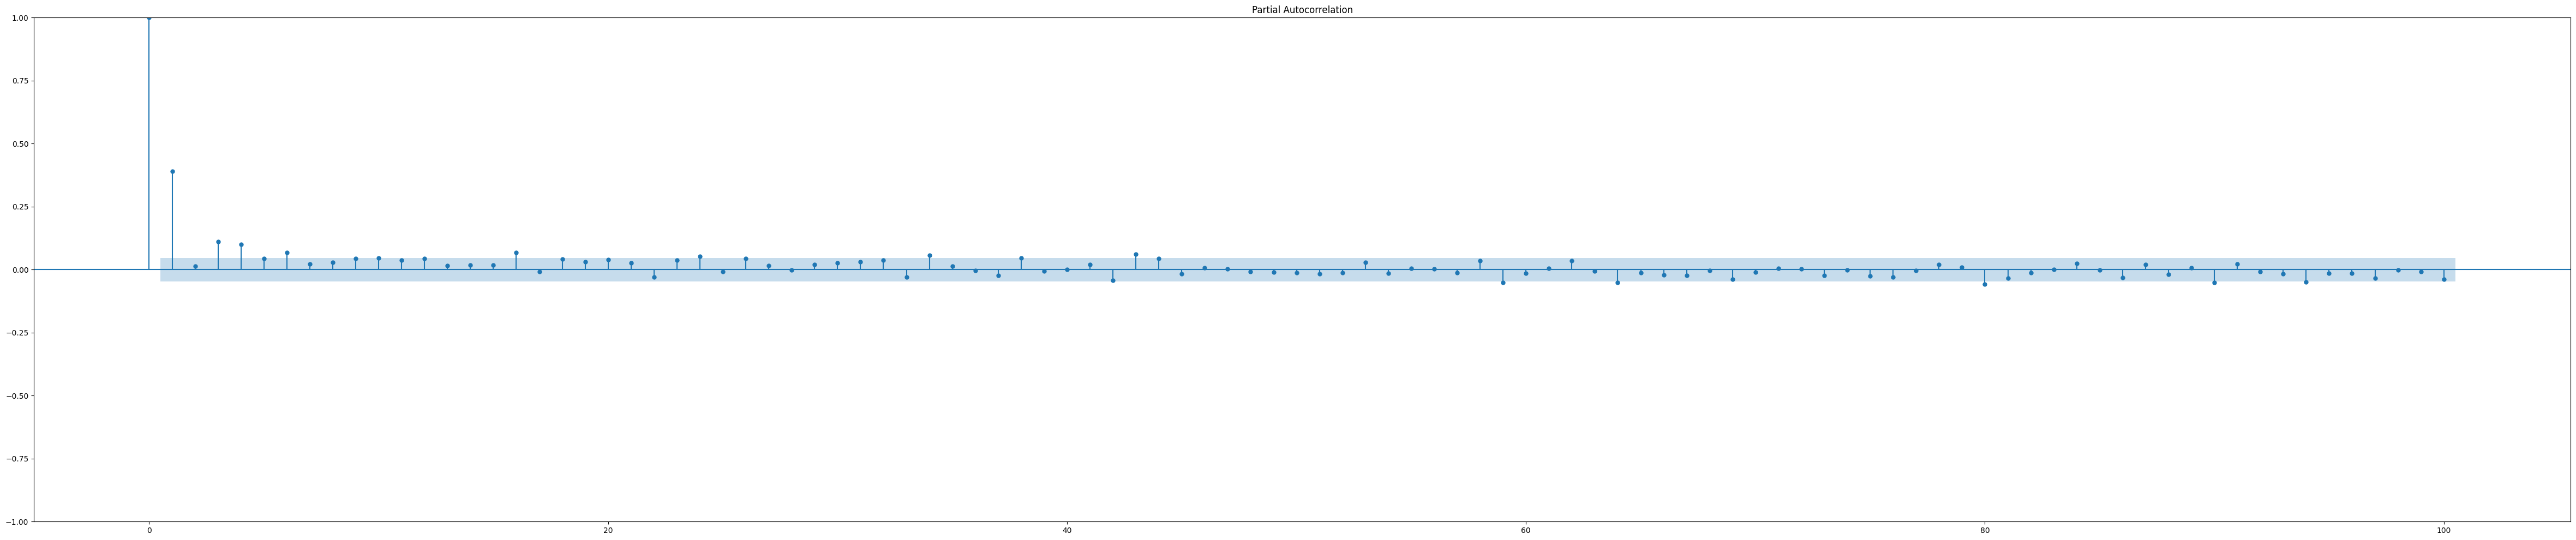

In [ ]:
#@title acf and pacf plots
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Create a figure and axes with the desired figsize
fig, ax = plt.subplots(figsize=(60, 12))

# Plot the PACF on the created axes
plot_acf(df['y'].dropna(), lags=100, alpha=0.05, ax=ax)

# Create a figure and axes with the desired figsize
fig, ax = plt.subplots(figsize=(60, 12))

# Plot the PACF on the created axes
plot_pacf(df['y'].dropna(), lags=100, alpha=0.05, ax=ax)

plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Define the split points
df_ar = df[['y','y_lagged', 'log_return_y', 'daily_ma_wind', 'wind_power_Moving_sub']]
test_start = '2021-01-01'
test_end = '2021-03-31'
train_start = '2020-01-01'
train_end = '2020-09-30'
val_start = '2020-10-01'
val_end = '2020-12-31'

# Create the splits
test_set = df_ar.loc[test_start:test_end]
train_set = df_ar.loc[train_start:train_end]
val_set = df_ar.loc[val_start:val_end]

# Fit the SARIMAX model with specified parameters including seasonal components
model_sarimax = sm.tsa.SARIMAX(
    train_set['y'],
    exog=train_set[['y_lagged', 'log_return_y', 'daily_ma_wind', 'wind_power_Moving_sub']],
    order=(2, 1, 2),  # ARIMA parameters: p, d, q
    seasonal_order=(1, 1, 1, 48)  # Seasonal parameters: (P, D, Q, s)
)
result = model_sarimax.fit(disp=False)
print(result.summary())

# Predict on the validation set
start_index_val = len(train_set)
end_index_val = start_index_val + len(val_set) - 1
val_predictions = result.predict(
    start=start_index_val,
    end=end_index_val,
    exog=val_set[['y_lagged', 'log_return_y', 'daily_ma_wind', 'wind_power_Moving_sub']]
)

mse_val = mean_squared_error(val_set['y'], val_predictions)
print(f'Mean Squared Error on Validation Set: {mse_val}')
mae_val = mean_absolute_error(val_set['y'], val_predictions)
print(f'Mean Absolute Error (MAE) on Validation Set: {mae_val}')
r2_val = r2_score(val_set['y'], val_predictions)
print(f'R-squared (R²) on Validation Set: {r2_val}')

# Combine all exogenous data to ensure full range is covered
combined_exog = pd.concat([train_set, val_set, test_set])
exog_test = combined_exog[['y_lagged', 'log_return_y', 'daily_ma_wind', 'wind_power_Moving_sub']].values[start_index_val:end_index_val+1]

if len(exog_test) < (end_index_val - start_index_val + 1):
    last_known_values = exog_test[-1]
    exog_test = np.pad(exog_test, ((0, end_index_val - start_index_val + 1 - len(exog_test)), (0, 0)), 'constant', constant_values=last_known_values)

start_index_test = len(train_set) + len(val_set)
end_index_test = start_index_test + len(test_set) - 1

# Predict on the test set
test_predictions = result.predict(
    start=start_index_test,
    end=end_index_test,
    exog=exog_test
)

mse_test = mean_squared_error(test_set['y'], test_predictions[:len(test_set)])
print(f'Mean Squared Error on Test Set: {mse_test}')
mae_test = mean_absolute_error(test_set['y'], test_predictions[:len(test_set)])
print(f'Mean Absolute Error (MAE) on Test Set: {mae_test}')
r2_test = r2_score(test_set['y'], test_predictions[:len(test_set)])
print(f'R-squared (R²) on Test Set: {r2_test}')


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  274
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 48)   Log Likelihood                2062.453
Date:                              Wed, 31 Jul 2024   AIC                          -4102.906
Time:                                      00:25:29   BIC                          -4065.328
Sample:                                  01-01-2020   HQIC                         -4087.739
                                       - 09-30-2020                                         
Covariance Type:                                opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
y_lagged                  0.9998   1.39e-05   7.18e+04      0.000       1.00

ValueError: Provided exogenous values are not of the appropriate shape. Required (182, 4), got (92, 4).

#Hyperparameter tuning Grid search and CV

#Prophet parameter tuning and CV

In [ ]:
#@title Cross validation and parameter tuning
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model_prophet, initial='365.25 days', period='180 days', horizon='365days')
df_p = performance_metrics(df_cv)
df_p#[df_p['mae'] <= 0.13]

INFO:prophet:Making 2 forecasts with cutoffs between 2018-07-04 23:00:00 and 2018-12-31 23:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8i3dy4j/6kpal679.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8i3dy4j/s7o00gc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47061', 'data', 'file=/tmp/tmpw8i3dy4j/6kpal679.json', 'init=/tmp/tmpw8i3dy4j/s7o00gc8.json', 'output', 'file=/tmp/tmpw8i3dy4j/prophet_modeltsqtgfs4/prophet_model-20240725062805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8i3dy4j/3c3smlx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw8i3dy4j/86_zwsgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

#LSTM Hyperparameter Gridsearch and CV

In [ ]:
# @title  Trial model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
features = ['temperature_2m' ,	'relativehumidity_2m' 	,'dewpoint_2m' ,	'windspeed_10m' ,	'windspeed_100m', 	'sin_winddirection_10m' 	,'sin_winddirection_100m' ,	'windgusts_10m']

# Define the LSTM model
model_LSTM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25,activation='sigmoid'),
    Dense(1)
])

model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

# @title Train the model
history = model_LSTM.fit(X_train, y_train, batch_size=64, epochs=50, validation_split=0.2)


Epoch 1/50
438/438 [==============================] - 48s 95ms/step - loss: 0.0456 - val_loss: 0.0328
Epoch 2/50
438/438 [==============================] - 39s 89ms/step - loss: 0.0344 - val_loss: 0.0308
Epoch 3/50
438/438 [==============================] - 41s 94ms/step - loss: 0.0326 - val_loss: 0.0308
Epoch 4/50
438/438 [==============================] - 39s 90ms/step - loss: 0.0315 - val_loss: 0.0293
Epoch 5/50
438/438 [==============================] - 39s 88ms/step - loss: 0.0298 - val_loss: 0.0277
Epoch 6/50
438/438 [==============================] - 44s 102ms/step - loss: 0.0287 - val_loss: 0.0267
Epoch 7/50
438/438 [==============================] - 40s 91ms/step - loss: 0.0281 - val_loss: 0.0263
Epoch 8/50
438/438 [==============================] - 39s 90ms/step - loss: 0.0274 - val_loss: 0.0258
Epoch 9/50
438/438 [==============================] - 42s 97ms/step - loss: 0.0267 - val_loss: 0.0261
Epoch 10/50
438/438 [==============================] - 42s 96ms/step - loss: 0.02

In [ ]:
#@title Grid search Hyperparameter Tuning for LSTM for google colab A100GPU


import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Install necessary libraries
#!pip install scikeras

import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping

# Check if GPU is available
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
#    print("Using GPU")
#else:
#    print("Using CPU")
"""
features = ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'windspeed_10m', 'windspeed_100m', 'windgusts_10m', 'sin_hour',
       'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month',
       'sin_winddirection_10m', 'cos_winddirection_10m',
       'sin_winddirection_100m', 'cos_winddirection_100m',
       'Windspeed_10m_lagged_1', 'Windspeed_10m_lagged_2',
       'Windspeed_100m_lagged_1', 'Windspeed_100m_lagged_2', 'daily_ma_wind',
       'weekly_ma_wind', 'monthly_ma_wind', 'quarterly_ma_wind',
       'temperature_sum', 'temperature_diff', 'Q_Div_Temp_wind',
       'log_Wind_100m', 'temp_lagged', 'Temp_Moving_sub', 'Wind_Moving_sub']
"""
features =['windspeed_100m', 'cos_hour', 'cos_month', 'Windspeed_100m_lagged_1',
       'Windspeed_100m_lagged_2', 'daily_ma_wind', 'weekly_ma_wind',
       'monthly_ma_wind', 'quarterly_ma_wind', 'temp_lagged']

# Define a dictionary to map optimizer names to actual Keras optimizer classes
optimizers_dict = {
    'SGD': tf.keras.optimizers.SGD,
    'Adam': tf.keras.optimizers.Adam
}

# Define your model creation function
def create_model(num_units=64, activation='sigmoid', optimizer='Adam', learning_rate=0.001, window_size=5):
    model = Sequential([
        LSTM(num_units, return_sequences=True, input_shape=(window_size, len(features))),
        Dropout(0.2),
        LSTM(num_units, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation=activation),
        Dense(1)
    ])
    optimizer = optimizers_dict[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create a function that returns KerasRegressor with different window sizes
def create_keras_regressor(window_size):
    return KerasRegressor(
        build_fn=create_model,
        num_units=64,
        activation='sigmoid',
        optimizer='Adam',
        learning_rate=0.001,
        window_size=window_size,
        verbose=0
    )

# Create a list of KerasRegressor models with different window sizes
models = [create_keras_regressor(ws) for ws in [5, 10, 15, 20]]

# Define your hyperparameter search space
param_dist = {
    'num_units': [32, 64, 128],
    'activation': ['sigmoid', 'relu'],
    'optimizer': ['SGD', 'Adam'],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform random search with cross-validation for each model
best_params = []
for model in models:
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,  # Number of random combinations to try
        cv=3,  # Number of cross-validation folds
        scoring='neg_mean_squared_error',  # Use an appropriate metric
        verbose=2,
        n_jobs=-1  # Use all available cores (if applicable)
    )
    random_search.fit(X_train, y_train, callbacks=[early_stopping])
    best_params.append(random_search.best_params_)

# Print the best hyperparameters found for each window size
for ws, params in zip([5, 10, 15, 20], best_params):
    print(f"Best params for window size {ws}: {params}")

"""
Best params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 15: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Best params for window size 20: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}

"""

#Best params for window size 5: {'optimizer': 'Adam', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'sigmoid'}
#Best params for window size 10: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}
#Best params for window size 15: {'optimizer': 'Adam', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
#Best params for window size 20: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}

Num GPUs Available:  1
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self.

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a 

Best params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Best params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 15: {'optimizer': 'SGD', 'num_units': 128, 'learning_rate': 0.001, 'activation': 'sigmoid'}
Best params for window size 20: {'optimizer': 'Adam', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'sigmoid'}


"\nBest params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}\nBest params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}\nBest params for window size 15: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}\nBest params for window size 20: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}\n\n"

In [ ]:
#@title Training the model1
def build_final_model(window_size, num_units, activation, optimizer, learning_rate):
    model = Sequential([
        LSTM(num_units, return_sequences=True, input_shape=(window_size, len(features))),
        Dropout(0.2),
        LSTM(num_units, return_sequences=False),
        Dropout(0.2),
        Dense(25,activation=activation),
        Dense(1)
    ])
    optimizer = optimizers_dict[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Using the best parameters for window size 5
final_model = build_final_model(
    window_size=5,
    num_units=64,
    activation='sigmoid',
    optimizer='SGD',
    learning_rate=0.01
)

"""
3 train 530s
Best params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Best params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 15: {'optimizer': 'SGD', 'num_units': 128, 'learning_rate': 0.001, 'activation': 'sigmoid'}
Best params for window size 20: {'optimizer': 'Adam', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'sigmoid'}
"""

# Train the final model
final_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - loss: 0.0764 - val_loss: 0.0404
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 0.0501 - val_loss: 0.0349
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.0453 - val_loss: 0.0335
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0435 - val_loss: 0.0333
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.0429 - val_loss: 0.0312
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 0.0426 - val_loss: 0.0305
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 0.0410 - val_loss: 0.0297
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 0.0406 - val_loss: 0.0310
Epoch 9/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.0400 - val_loss: 0.0292
Epoch 10/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0395 - val_loss: 0.0288
Epoch 11/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.0393 - val_loss: 0.0294
Epoch 12/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# @title Training the model2
def build_final_model(window_size, num_units, activation, optimizer, learning_rate):
    model = Sequential([
        LSTM(num_units, return_sequences=True, input_shape=(window_size, len(features))),
        Dropout(0.2),
        LSTM(num_units, return_sequences=False),
        Dropout(0.2),
        Dense(25,activation=activation),
        Dense(1)
    ])
    optimizer = optimizers_dict[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Using the best parameters for window size 5
final_model2 = build_final_model(
    window_size=10,
    num_units=32,
    activation='relu',
    optimizer='SGD',
    learning_rate=0.01
)

#Best params for window size 10: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}
#Best params for window size 15: {'optimizer': 'Adam', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
#Best params for window size 20: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
"""
Best params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 15: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Best params for window size 20: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}
"""
"""
85s
3
Best params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Best params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 15: {'optimizer': 'SGD', 'num_units': 128, 'learning_rate': 0.001, 'activation': 'sigmoid'}
Best params for window size 20: {'optimizer': 'Adam', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'sigmoid'}
"""

# Train the final model
final_model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0664 - val_loss: 0.0397
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0499 - val_loss: 0.0347
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0461 - val_loss: 0.0328
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.0447 - val_loss: 0.0322
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0434 - val_loss: 0.0319


In [ ]:
# @title Training the model3
def build_final_model(window_size, num_units, activation, optimizer, learning_rate):
    model = Sequential([
        LSTM(num_units, return_sequences=True, input_shape=(window_size, len(features))),
        Dropout(0.2),
        LSTM(num_units, return_sequences=False),
        Dropout(0.2),
        Dense(25,activation=activation),
        Dense(1)
    ])
    optimizer = optimizers_dict[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Using the best parameters for window size 5
final_model3 = build_final_model(
    window_size=15,
    num_units=128,
    activation='sigmoid',
    optimizer='SGD',
    learning_rate=0.01
)

"""
2
Best params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 15: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Best params for window size 20: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}

"""
"""
3 101s
Best params for window size 5: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
Best params for window size 10: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}
Best params for window size 15: {'optimizer': 'SGD', 'num_units': 128, 'learning_rate': 0.001, 'activation': 'sigmoid'}
Best params for window size 20: {'optimizer': 'Adam', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'sigmoid'}
"""

#Best params for window size 10: {'optimizer': 'SGD', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'relu'}
#Best params for window size 15: {'optimizer': 'Adam', 'num_units': 64, 'learning_rate': 0.01, 'activation': 'sigmoid'}
#Best params for window size 20: {'optimizer': 'SGD', 'num_units': 32, 'learning_rate': 0.01, 'activation': 'relu'}

# Train the final model
final_model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 0.0703 - val_loss: 0.0390
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 0.0482 - val_loss: 0.0347
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0453 - val_loss: 0.0335
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0435 - val_loss: 0.0315
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - loss: 0.0428 - val_loss: 0.0313


#XGB Hyper parameter tuning,Grid Search and CV

In [ ]:
#@title Hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
# Define the model with GPU support
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # Use GPU for training
    gpu_id=0                 # Specify GPU device, if you have more than one
)


'''
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300, 400, 500],
    'alpha': [0, 10, 20, 30]
}
'''


param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'n_estimators': [200, 300],
    'alpha': [0, 10]
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1  # Note: This will use CPU cores for parallel grid search; GPU is used for model training
)


# Fit the grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(f'Best Parameters: {best_params}')
print(f'Mean Squared Error on Test Set: {mse}')
#Fitting 3 folds for each of 5120 candidates, totalling 15360 fits
#Fitting 3 folds for each of 64 candidates, totalling 192 fits


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters: {'alpha': 10, 'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
Mean Squared Error on Test Set: 0.02398572431452394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:28:47] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:28:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [

In [ ]:
#@title Hyperparameter
#pip install lightgbm catboost xgboost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
# Define the models with GPU support for XGBoost and CatBoost, CPU for LightGBM
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # Use CUDA for training
    device='cuda'        # Specify CUDA device
)

model_lgb = lgb.LGBMRegressor(
    objective='regression'
    # Using CPU, remove GPU parameters
)

model_cb = cb.CatBoostRegressor(
    loss_function='RMSE',
    task_type='GPU',
    devices='0',
    verbose=0
)

# Define the parameter grid for each model
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.4, 0.7, 0.8, 0.9, 1],
    'n_estimators': [100, 200, 300, 400, 500],
    'alpha': [0, 10, 20, 30]
}

param_grid_lgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.4, 0.7, 0.8, 0.9, 1],
    'n_estimators': [100, 200, 300, 400, 500],
    'reg_alpha': [0, 10, 20, 30]
}

param_grid_cb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [3, 4, 5, 6],
    'bagging_temperature': [0.6, 0.7, 0.8, 0.9],
    'colsample_bylevel': [0.4, 0.7, 0.8, 0.9, 1],
    'iterations': [100, 200, 300, 400, 500],
    'l2_leaf_reg': [0, 10, 20, 30]
}

# Set up RandomizedSearchCV for each model
random_search_xgb = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_grid_xgb,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_lgb = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_grid_lgb,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_cb = RandomizedSearchCV(
    estimator=model_cb,
    param_distributions=param_grid_cb,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=3)

# Fit the randomized searches
random_search_xgb.fit(X_train, y_train)
random_search_lgb.fit(X_train, y_train)
random_search_cb.fit(X_train, y_train)

# Retrieve the best models
best_model_xgb = random_search_xgb.best_estimator_
best_model_lgb = random_search_lgb.best_estimator_
best_model_cb = random_search_cb.best_estimator_

# Stacking ensemble
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', best_model_xgb),
        ('lgb', best_model_lgb),
        ('cb', best_model_cb)
    ],
    final_estimator=Ridge()
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the stacking model on the test set
predictions = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Squared Error on Test Set: {mse}')


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


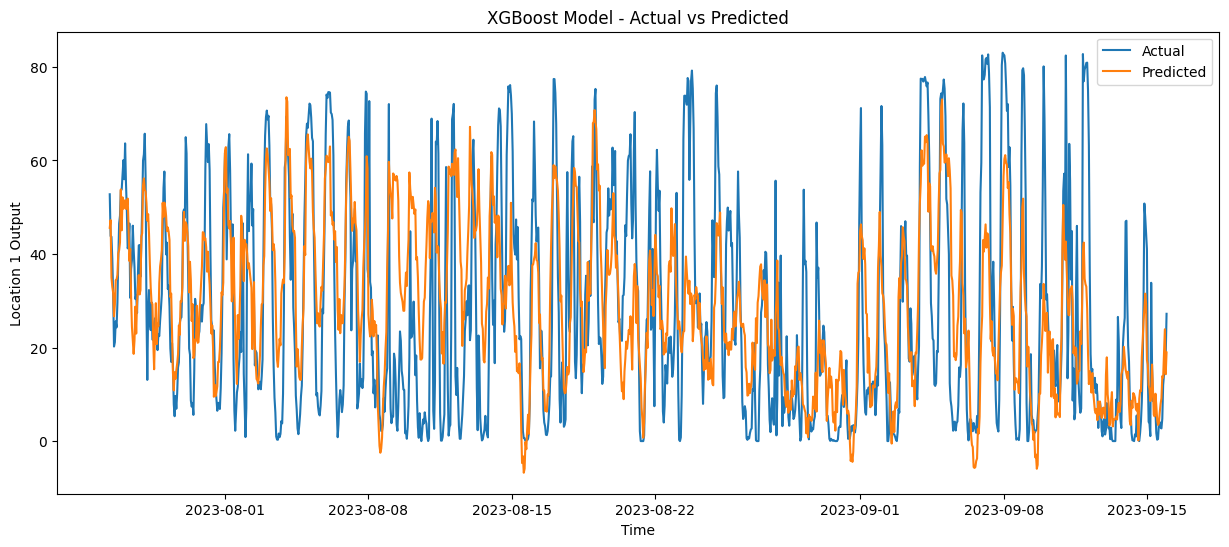

In [ ]:
#@title Plotting old
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.title('XGBoost Model - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Location 1 Output')
plt.legend()
plt.show()


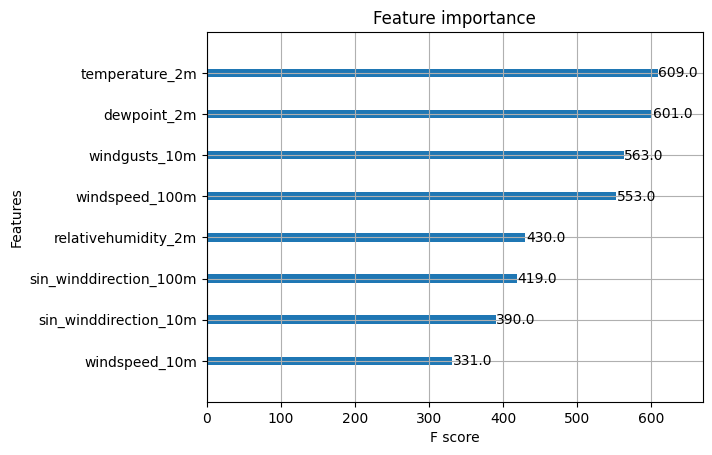

In [ ]:
#@title Plot feature importance
xgb.plot_importance(model_xgb)
plt.show()